In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionResNetV2

from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers, Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
batch_size = 64

In [11]:
# rescale normalizes the data for the images.
# Data is split into train and validation sets
image_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split=0.2)

train_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/tb2/TB_Chest_Radiography_Database',
                                              target_size=(299, 299),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='training'
                                             )

val_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/tb2/TB_Chest_Radiography_Database',
                                              target_size=(299, 299),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='validation'
                                             )

test_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TestImages for TB',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              shuffle = False,
                                              class_mode='binary',
                                             )

Found 4264 images belonging to 2 classes.
Found 1066 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [12]:
dnn201 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_tensor=None,
    input_shape=(299,299,3),
    weights = 'imagenet'
)

dnn201.trainable= False

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = Dense(1, activation='sigmoid')

model = Sequential([
    dnn201,
    global_avg_layer,
    
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    predictions
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

219062272/219055592 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_______________________________________________________

In [14]:
epochs = 10
histort = model.fit(train_it,
                       validation_data=val_it, epochs=epochs )
#model.save('InceptionResNetV2')

Epoch 1/10
67/67 [==============================] - 3458s 51s/step - loss: 0.3538 - accuracy: 0.8569 - val_loss: 0.7594 - val_accuracy: 0.6792
Epoch 2/10
67/67 [==============================] - 150s 2s/step - loss: 0.1708 - accuracy: 0.9394 - val_loss: 0.4124 - val_accuracy: 0.8161
Epoch 3/10
67/67 [==============================] - 149s 2s/step - loss: 0.1665 - accuracy: 0.9345 - val_loss: 0.1854 - val_accuracy: 0.9146
Epoch 4/10
67/67 [==============================] - 150s 2s/step - loss: 0.1329 - accuracy: 0.9530 - val_loss: 0.1531 - val_accuracy: 0.9353
Epoch 5/10
67/67 [==============================] - 150s 2s/step - loss: 0.1143 - accuracy: 0.9541 - val_loss: 0.1018 - val_accuracy: 0.9606
Epoch 6/10
67/67 [==============================] - 150s 2s/step - loss: 0.1123 - accuracy: 0.9610 - val_loss: 0.0785 - val_accuracy: 0.9700
Epoch 7/10
67/67 [==============================] - 150s 2s/step - loss: 0.1022 - accuracy: 0.9608 - val_loss: 0.0993 - val_accuracy: 0.9653
Epoch 8/10


In [ ]:
#results = model.evaluate(val_it)

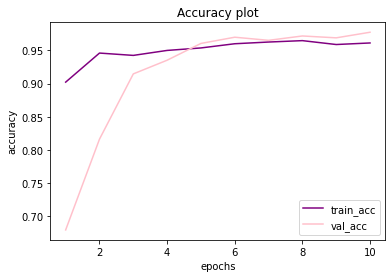

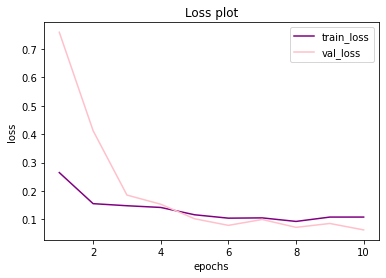

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs= range(1, len(histort.history["accuracy"])+1)

plt.plot(epochs, histort.history["accuracy"], color="purple")
plt.plot(epochs, histort.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, histort.history["loss"], color="purple")
plt.plot(epochs, histort.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [26]:
results = model.evaluate(val_it)

17/17 [==============================] - 30s 2s/step - loss: 0.0676 - accuracy: 0.9775


In [31]:

prediction= model.predict(val_it, verbose=2)
prediction= (prediction > 0.5)
prediction

17/17 - 28s


array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [33]:
val_labels=val_it.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

0.5337711069418386
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       700
           1       0.32      0.31      0.31       366

    accuracy                           0.53      1066
   macro avg       0.48      0.48      0.48      1066
weighted avg       0.53      0.53      0.53      1066



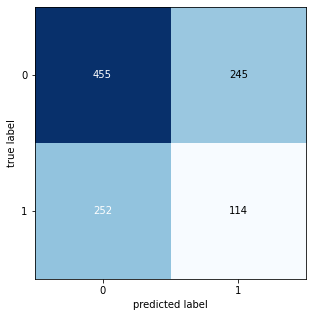

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(val_it.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))
print(accuracy_score(val_it.classes, prediction))
print(classification_report(val_it.classes, prediction))

In [35]:
results = model.evaluate(test_it)


4/4 [==============================] - 78s 25s/step - loss: 0.7103 - accuracy: 0.8050


In [37]:
prediction1 = model.predict(test_it)
prediction1 = (prediction1 > 0.5)
prediction1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

0.805
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       100
           1       1.00      0.61      0.76       100

    accuracy                           0.81       200
   macro avg       0.86      0.80      0.80       200
weighted avg       0.86      0.81      0.80       200



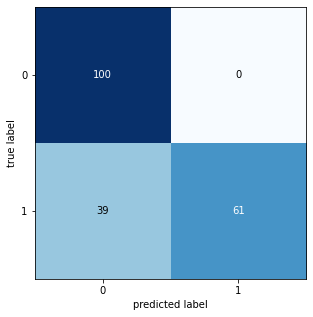

In [38]:
cm1 = confusion_matrix(test_it.classes, prediction1)
plot_confusion_matrix(cm1, figsize=(5,5))
print(accuracy_score(test_it.classes, prediction1))
print(classification_report(test_it.classes, prediction1))